# Streaming LDA, QDA ,and RDA with dummy datasets

The goal of this notebook is to showcase SQDA and SRDA in a low dimensional simple problem.

We take on the problem of binary classification in two dimension where we generate two datasets:

- The first one consists of two classes following the same gaussian distribution but with different means.
- The second one consists of two classes following two different gaussian ditribution with differents means and covariance matrices.

In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl

from scipy import linalg
import numpy as np
import torch

from sqda import StreamingQDA
from slda import StreamingLDA
from srda import StreamingRDA

### Color map

In [2]:

cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)

/tmp/ipykernel_15891/2778021156.py:9: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.cm.register_cmap(cmap=cmap)


### Datasets generation functions

In [3]:
def dataset_fixed_cov(nb_samples=600,ratio=0.5):
    """Generate 2 Gaussians samples with the same covariance matrix"""
    dim = 2
    np.random.seed(100)
    C = np.array([[0.0, -0.23], [0.83, 0.23]])
    X = np.r_[
        np.dot(np.random.randn(int(nb_samples*ratio), dim), C),
        np.dot(np.random.randn(int(nb_samples*(1-ratio)), dim), C) + np.array([1, 1]),
    ]
    y = np.hstack((np.zeros(int(nb_samples*ratio)), np.ones(int(nb_samples*(1-ratio)))))
    return X, y


def dataset_cov(nb_samples=600,ratio=0.5):
    """Generate 2 Gaussians samples with different covariance matrices"""
    dim = 2
    np.random.seed(100)
    C = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
    X = np.r_[
        np.dot(np.random.randn(int(nb_samples*ratio), dim), C),
        np.dot(np.random.randn(int(nb_samples*(1-ratio)), dim), C.T) + np.array([1, 4]),
    ]
    y = np.hstack((np.zeros(int(nb_samples*ratio)), np.ones(int(nb_samples*(1-ratio)))))
    return X, y

### Plot functions

In [4]:
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        plt.ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    elif fig_index == 3:
        plt.ylabel("Data with\n varying covariances")

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        angle=180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")

In [5]:
def s_plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 3, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        plt.ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    elif fig_index == 3:
        plt.title("Regularized Discriminant Analysis")
    elif fig_index == 4:
        plt.ylabel("Data with\n varying covariances")
    

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float(),return_probas=True)
    Z = Z.numpy()
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.muK[0][0],
        lda.muK[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.muK[1][0],
        lda.muK[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    return splot

## Regular lda qda

In [6]:
dataset1=dataset_fixed_cov(ratio=0.5)
dataset2=dataset_cov(ratio=0.5)

LDA Report
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       300
         1.0       0.92      0.96      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600

QDA Report
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       300
         1.0       0.93      0.96      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600

LDA Report
              precision    recall  f1-score   support

         0.0       0.70      0.74      0.72       300
         1.0       0.73      0.69      0.71       300

    accuracy                           0.71       600
   macro avg       0.72      0.71      0.71       600
weighted avg       0.72      0.71      0.

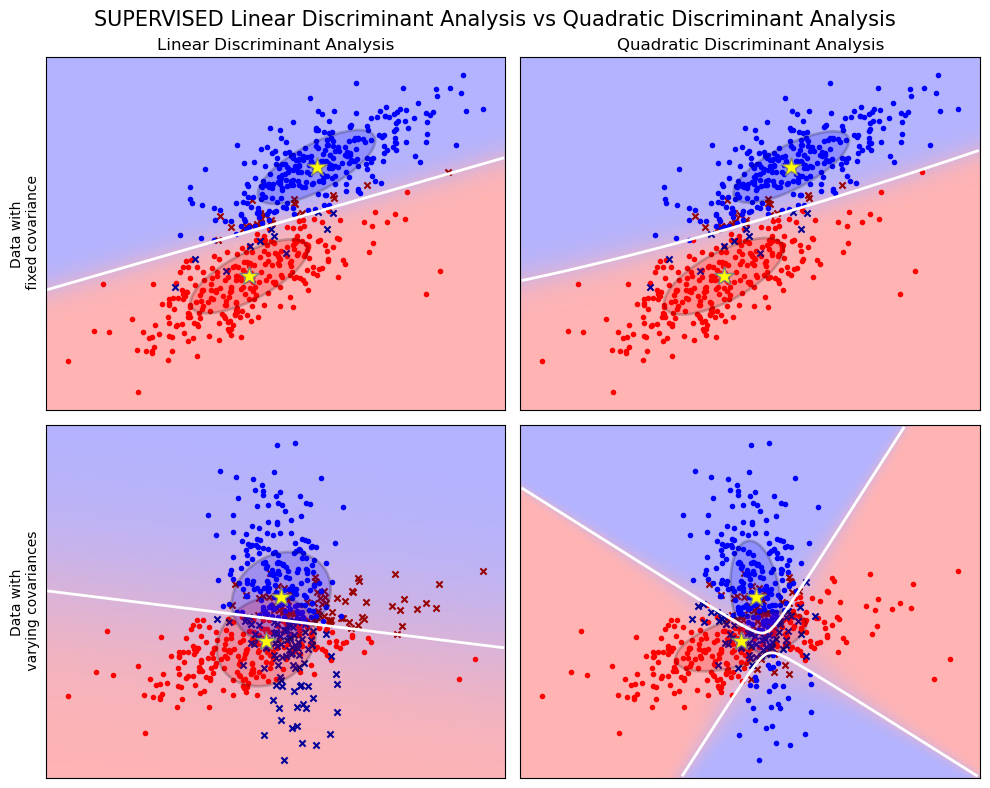

In [7]:
plt.figure(figsize=(10, 8), facecolor="white")
plt.suptitle(
    "SUPERVISED Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.98,
    fontsize=15,
)
for i, (X, y) in enumerate([dataset1,dataset2]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")
    print("LDA Report")
    print(classification_report(y,y_pred))

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis("tight")
    print("QDA Report")
    print(classification_report(y,y_pred))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

## Streaming


First predict since model update...computing Lambda matrix...
SLDA Report
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       300
         1.0       0.92      0.96      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600


First predict since model update...computing Lambda matrix...
SLDA Report
              precision    recall  f1-score   support

         0.0       0.70      0.74      0.72       300
         1.0       0.73      0.69      0.71       300

    accuracy                           0.71       600
   macro avg       0.72      0.71      0.71       600
weighted avg       0.72      0.71      0.71       600

SQDA Report
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       300
         1.0       0.93      0.96      0.94       300

    accuracy        

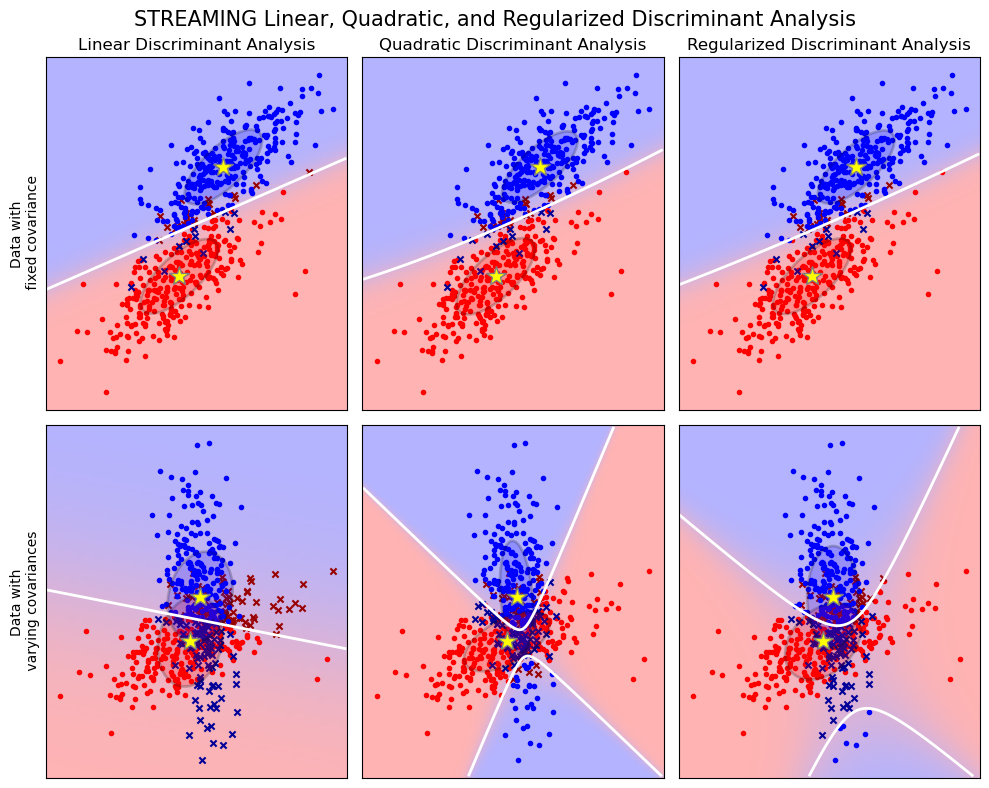

In [8]:
plt.figure(figsize=(10, 8), facecolor="white")
plt.suptitle(
    "STREAMING Linear, Quadratic, and Regularized Discriminant Analysis",
    y=0.98,
    fontsize=15,
)
for i,dataset in enumerate([dataset1,dataset2]):
    s_lda=StreamingLDA(input_shape=2,num_classes=2,test_batch_size=10)
    s_lda.to(torch.device('cpu'))
    for x,y in zip(dataset[0],dataset[1]):
        s_lda.fit(torch.tensor(x).squeeze(),torch.tensor(y,dtype=torch.int).squeeze())
    y_pred= torch.argmax(s_lda.predict(torch.from_numpy(dataset[0]).float(),return_probas=False),dim=1).numpy()
    splot = s_plot_data(s_lda, dataset[0], dataset[1], y_pred,fig_index=3*i+1)
    plot_ellipse(splot, s_lda.muK[0].numpy(), s_lda.Sigma.numpy(), "red")
    plot_ellipse(splot, s_lda.muK[1].numpy(), s_lda.Sigma.numpy(), "blue")
    plt.axis("tight")
    print("SLDA Report")
    print(classification_report(dataset[1],y_pred))

for i,dataset in enumerate([dataset1,dataset2]):
    s_qda=StreamingQDA(input_size=2,num_classes=2,test_batch_size=10,device=torch.device('cpu'))
    s_qda.to(torch.device('cpu'))
    for x,y in zip(dataset[0],dataset[1]):
        s_qda.fit(torch.tensor(x).squeeze(),torch.tensor(y,dtype=torch.int).squeeze())
    y_pred= torch.argmax(s_qda.predict(torch.from_numpy(dataset[0]).float(),return_probas=False),dim=1).numpy()
    splot = s_plot_data(s_qda, dataset[0], dataset[1], y_pred,fig_index=3*i+2)
    plot_ellipse(splot, s_qda.muK[0].numpy(), s_qda.SigmaK[0].numpy(), "red")
    plot_ellipse(splot, s_qda.muK[1].numpy(), s_qda.SigmaK[1].numpy(), "blue")
    plt.axis("tight")
    print("SQDA Report")
    print(classification_report(dataset[1],y_pred))

for i,dataset in enumerate([dataset1,dataset2]):
    s_rda=StreamingRDA(input_size=2,num_classes=2,test_batch_size=10,alpha=0.5,device=torch.device('cpu'))
    s_rda.to(torch.device('cpu'))
    for x,y in zip(dataset[0],dataset[1]):
        s_rda.fit(torch.tensor(x).squeeze(),torch.tensor(y,dtype=torch.int).squeeze())
    y_pred= torch.argmax(s_rda.predict(torch.from_numpy(dataset[0]).float(),return_probas=False),dim=1).numpy()
    splot = s_plot_data(s_rda, dataset[0], dataset[1], y_pred,fig_index=3*i+3)
    plot_ellipse(splot, s_rda.muK[0].numpy(), s_rda.RegSigmaK[0].numpy(), "red")
    plot_ellipse(splot, s_rda.muK[1].numpy(), s_rda.RegSigmaK[1].numpy(), "blue")
    plt.axis("tight")
    print("SRDA Report")
    print(classification_report(dataset[1],y_pred))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()
